In [46]:
#import necessary packages
from datetime import datetime
#import it in console with: pip install pandas-datareader
import pandas_datareader.data as wb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style

In [47]:
# Input
# ticker: list of chosen stock
# start_date: start date of search in YYYY-M-D format
# end_date: end date of search in YYYY-M-D format
# Output Pandas dataframe with finance data from Yahoo
def get_data_from_api(ticker, start_date, end_date):
    dataframe = wb.DataReader(ticker, 'yahoo', start_date, end_date)
    return dataframe

In [55]:
#Preprocess data
def process_data(raw_df, standarize, drop_standard, calculations):
        #Set index as datetime
        raw_df.index = pd.to_datetime(raw_df.index)
        #Set label by shifting Closing price by -1
        raw_df['Label'] = raw_df['Close'].shift(-1)
        #Creating more features
        #Log_r
        log_r = np.log(raw_df['Close'] / raw_df['Close'].shift(1))
        max_roll_window = 0
        #Check which calculations should be applied
        if 'MA5' in calculations:
            raw_df['MA5'] = raw_df['Close'].rolling(5).mean()
            max_roll_window = 5
        if 'MA20' in calculations:
            raw_df['MA20'] = raw_df['Close'].rolling(20).mean()
            max_roll_window = 20
        if 'MIN' in calculations:
            raw_df['MIN'] = raw_df['Close'].rolling(max_roll_window).min()
        if 'MAX' in calculations:
            raw_df['MAX'] = raw_df['Close'].rolling(max_roll_window).max()
        if 'mom' in calculations:
            raw_df['mom'] = log_r.rolling(max_roll_window).mean()
            print(max_roll_window)
        if 'vola' in calculations:
            raw_df['vola'] = log_r.rolling(max_roll_window).std()

        #Drop non-used columns
        if drop_standard:
            raw_df = raw_df.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis = 1)
        #Drop NaN values
        raw_df = raw_df.dropna()
        #Standarizing
        if standarize:
            raw_df = (raw_df - raw_df.mean())/raw_df.std()
        return raw_df

In [56]:
import math
#Split data into train and test sets
def split_data(df_input, percent):
    # Array splicing and splitting of data
    rdf = df_input.to_numpy()

    X, y = rdf[:, :-1], rdf[:, -1]

    # pct split
    limit = math.floor(len(X) * percent)

    X_train, X_test = X[:limit,:],X[limit:,:]

    y_train, y_test = y[:limit],y[limit:]
    print(X_train)
    return X_train, X_test, y_train, y_test

In [57]:
from sklearn.linear_model import LinearRegression
def linear_reg(X_train, X_test, y_train, y_test):
    model = LinearRegression().fit(X_train, y_train)
    model.score(X_test, y_test)
    predictions = model.predict(X_test)
    print("Actual: ", y_test[:3])
    print("Forecasted: ", predictions[:3])
    return predictions

In [58]:
# MLPRegression
## MLP Reg
from sklearn.neural_network import MLPRegressor
def MLP_reg(X_train, X_test, y_train, y_test, rnd_state, max_it):
    regr = MLPRegressor(random_state = rnd_state, max_iter = max_it).fit(X_train, y_train)
    print(regr.score(X_train, y_train))
    MLPpredictions = regr.predict(X_test)
    print(regr.score(X_test, y_test))
    return MLPpredictions

In [67]:
def experiment_1():
    # Get stock data of Microsoft from 1990-01-01 to 2021-05-05
    # Multile tickers
    ##tickerList = ['MSFT', 'AAPL']
    start = datetime(1990,1,1)
    end = datetime(2021,5,5)
    tickerList = 'MSFT'
    df = get_data_from_api(tickerList, start, end)
    print(df.head())
    
    #Process data
    #raw_df, standarize, drop_standard, calculations
    df_mod = process_data(df, False, True, ['MA5'])


    #Split data into train and test sets
    df_splitted = split_data(df_mod, 0.8)
    print("splitted")
    print(df_splitted)
    #Do linear regression
    linear_predictions = linear_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3])
    print("linear_predictions")
    print(linear_predictions)
    
    #MLPRegression
    rnd_state = 1
    max_it = 500
    MLP_predictions = MLP_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3], rnd_state, max_it)
    print("MLP_predictions")
    print(MLP_predictions)

    ##Visualize the predictions
    #Visualize to understand the model behaviour
    plt.figure(figsize = (15,8), dpi = 80)
    df_pred = pd.DataFrame(data = MLP_predictions, columns = ["Predictions"])
    df_pred["actual"] = df_splitted[3].tolist()
    df_pred["linear"] = linear_predictions.tolist()
    df_pred.plot()
    plt.show()

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
1990-01-02  0.616319  0.598090  0.605903  0.616319   53035200.0   0.391455
1990-01-03  0.626736  0.614583  0.621528  0.619792  113774400.0   0.393661
1990-01-04  0.638889  0.616319  0.619792  0.638021  125740800.0   0.405239
1990-01-05  0.638889  0.621528  0.635417  0.622396   69566400.0   0.395315
1990-01-08  0.631944  0.614583  0.621528  0.631944   58982400.0   0.401380
[[ 0.631944    0.63020802]
 [ 0.63020802  0.61284697]
 [ 0.61284697  0.600694  ]
 ...
 [47.13000107 47.18000031]
 [47.18000031 47.00999832]
 [47.00999832 42.65999985]]
splitted
(array([[ 0.631944  ,  0.63020802],
       [ 0.63020802,  0.61284697],
       [ 0.61284697,  0.600694  ],
       ...,
       [47.13000107, 47.18000031],
       [47.18000031, 47.00999832],
       [47.00999832, 42.65999985]]), array([[ 42.65999985,  41.18999863],
       [ 41.18999863,  42.00999832],

<Figure size 1200x640 with 0 Axes>

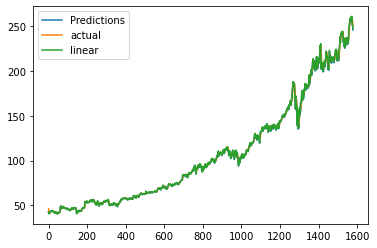

In [68]:
#Linear and Regression without standarizing the values
experiment_1()

In [ ]:
def experiment_2():
    # Get stock data of Microsoft from 1990-01-01 to 2021-05-05
    # Multile tickers
    ##tickerList = ['MSFT', 'AAPL']
    start = datetime(1990,1,1)
    end = datetime(2021,5,5)
    tickerList = 'MSFT'
    df = get_data_from_api(tickerList, start, end)

    #Process data
    #raw_df, standarize, drop_standard, calculations
    df_mod = process_data(df, True, True, [])
    df_mod.tail(5)

    #Split data into train and test sets
    df_splitted = split_data(df_mod, 0.8)

    #Do linear regression
    linear_predictions = linear_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3] )
    print("linear_predictions")
    print(linear_predictions)
    
    #MLPRegression
    rnd_state = 1
    max_it = 500
    MLP_predictions = MLP_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3], rnd_state, max_it)
    print("MLP_predictions")
    print(MLP_predictions)

    ##Visualize the predictions
    #Visualize to understand the model behaviour
    plt.figure(figsize = (15,8), dpi = 80)
    df_pred = pd.DataFrame(data = MLP_predictions, columns = ["Predictions"])
    df_pred["actual"] = df_splitted[3].tolist()
    df_pred["linear"] = linear_predictions.tolist()
    df_pred.plot()
    plt.show()

[[-0.85513624]
 [-0.85505901]
 [-0.85465366]
 ...
 [ 0.15226693]
 [ 0.17917337]
 [ 0.18028518]]
Actual:  [0.07898039 0.04633488 0.06454528]
Forecasted:  [0.17534276 0.07880894 0.04618713]
linear_predictions
[0.17534276 0.07880894 0.04618713 ... 4.7284117  4.72131054 4.63099019]
0.9983694910730384
0.8085780230637265
MLP_predictions
[0.17481136 0.08155363 0.04804226 ... 3.16681478 3.16266464 3.10987857]


<Figure size 1200x640 with 0 Axes>

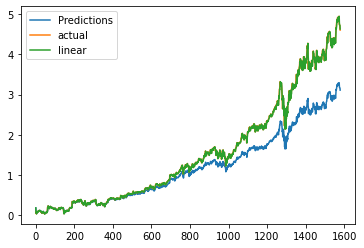

In [54]:
#Linear and MLP with standarized input
experiment_2()

In [ ]:
def experiment_3():
    # Get stock data about Microsoft from 1990-01-01 to 2021-05-05
    # Multile tickers
    ##tickerList = ['MSFT', 'AAPL']
    start = datetime(1990,1,1)
    end = datetime(2021,5,5)
    tickerList = 'MSFT'
    df = get_data_from_api(tickerList, start, end)

    #Process data
    #raw_df, standarize, drop_standard, calculations
    df_mod = process_data(df, True, True, ['MA5', 'MA20', 'MIN', 'MAX'])
    df_mod.tail(5)

    #Split data into train and test sets
    df_splitted = split_data(df_mod, 0.8)

    #Do linear regression
    linear_predictions = linear_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3] )
    print("linear_predictions")
    print(linear_predictions)
    
    #MLPRegression
    rnd_state = 1
    max_it = 500
    MLP_predictions = MLP_reg(df_splitted[0], df_splitted[1], df_splitted[2], df_splitted[3], rnd_state, max_it)
    print("MLP_predictions")
    print(MLP_predictions)

    ##Visualize the predictions
    #Visualize to understand the model behaviour
    plt.figure(figsize = (15,8), dpi = 80)
    df_pred = pd.DataFrame(data = MLP_predictions, columns = ["Predictions"])
    df_pred["actual"] = df_splitted[3].tolist()
    df_pred["linear"] = linear_predictions.tolist()
    df_pred.plot()
    plt.show()

In [ ]:
experiment_3()